### Bivariate Analysis of quantitative variables
In this part of the study, we will perform bivariate analysis on heart rate and evaluation position. In order to understand the relationship between these two variables, we will first use a scatterplot, and then we will check their correlation.

In [394]:
# Some imports
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats
from skfda.inference.anova import oneway_anova
from pingouin import multivariate_normality
from FDApy.preprocessing.smoothing.local_polynomial import LocalPolynomial
from FDApy.representation.simulation import Brownian
import FDApy
import torch
import skfda
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
from matplotlib.pyplot import figure
from FDApy.misc.loader import read_csv
from FDApy.preprocessing.dim_reduction.fpca import UFPCA
from FDApy.visualization.plot import plot

In [395]:
#Dataset import
realwage = pd.read_csv("partite.csv")
realwage = realwage.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])

In [396]:
# Function for calculation of the heart rate delta
def heart_rate_delta(dataframe, color,game):
    df = dataframe.iloc[:10]
    return np.sum(df[game][color]['HR'])//10

<AxesSubplot:xlabel='HR', ylabel='Evaluation'>

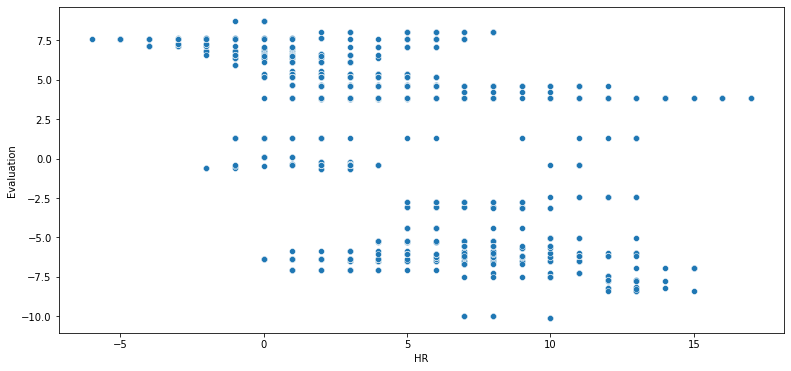

In [397]:
#Scatterplot
sns.scatterplot(x=realwage['Game0529-1']['b']['HR'], y=realwage['Game0529-1']['b']['Evaluation'], data=realwage)

Represented above a graph plotting the data of a single game, on the x axis the heartrate, on the y axis the position evaluation.

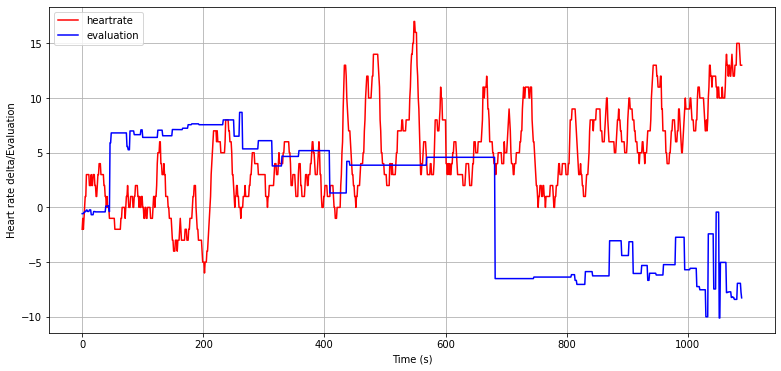

In [398]:
# Let's check a single game (Game0529-1). We are plotting both the delta of the heart rate and the evaluation of the same player at the same time

plt.rcParams["figure.figsize"] = (13,6)
hb = realwage['Game0529-1']['b']['HR'] - heart_rate_delta(realwage,'b','Game0529-1')

t = realwage.index
eb = realwage['Game0529-1']['b']['Evaluation']
plt.grid()
# plotting heart beats
plt.plot(t,hb, 'r')
# plotting evaluation
plt.plot(t,eb,'b')
plt.xlabel("Time (s)")
plt.ylabel("Heart rate delta/Evaluation")
plt.legend(['heartrate','evaluation'])
plt.show()


Here it's plotted the heartrate and evaluation during game time.

<AxesSubplot:>

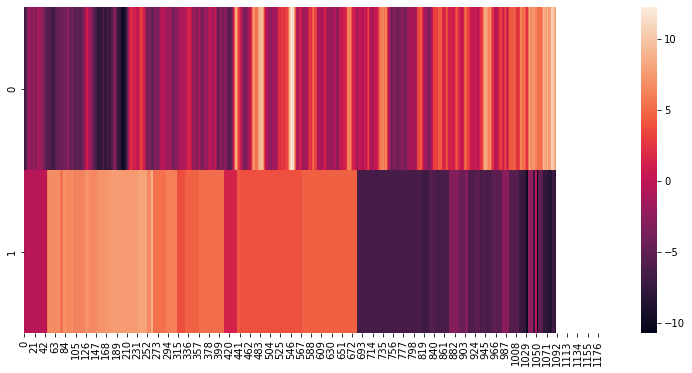

In [399]:
# Heatmap of correlation matrix

hrw = realwage['Game0529-1']['b']['HR'] - realwage['Game0529-1']['b']['HR'].mean()
evw=realwage['Game0529-1']['b']['Evaluation']
df = np.array([hrw,evw])
sns.heatmap(df)


In [400]:
# Correlation matrix
df1 = pd.DataFrame({'x2': hb,
                   'x3': eb})
df1.corr()


,x2,x3
x2,1.000000,-0.463782
x3,-0.463782,1.000000


We can notice that there is a slight anticorrelation in this game between the heartbeat and the evaluation position of this player, this means that when the player was winning (higher evaluation), his heart beat was decreasing, he was getting "calmer"; and when losing, the heartbeat was raising, indicating an emotional distress.

This single example doesn't provide general information, we will find more interesting correlations when considering all the games at the same time, in the functional analysis.

### Multivariate Normality Test
The multivariate normality test is used to determine whether a set of multivariate observations could come from a multivariate normal distribution. A multivariate normal distribution for m variables is characterized by m means, m variances and $ \frac{m(m-1)}{2} $ covariances or correlations and the marginal distribution of each variable is normal.

We decided to apply the Henze-Zirkler Multivariate Normality Test to check if our variables followed a multivariate normal distribution. The hypotesys for the test are:
- $ H_0 $: the variables come from a Multivariate Normal Distribution
- $ H_A $: the variables don't come from a Multivariate Normal Distribution

In [401]:


#create a dataset with three variables x1, x2, and x3
df = pd.DataFrame({'x1':t,
                   'x2': hb,
                   'x3': eb})

#perform the Henze-Zirkler Multivariate Normality Test
multivariate_normality(df, alpha=.05)



HZResults(hz=29.16836390373557, pval=3.8969463107127007e-138, normal=False)

Since in the above example, the p-value is 1.2e-130 which is less than the alpha(0.5) then we reject the null hypothesis i.e. we have sufficient evidence to say that sample does not come from a multivariate normal distribution.

We reject the null hypothesis, the variances of the samples ar not the same

## Functional Data Analysis 
#### Introduction

Thanks to a suggestion given by Professor Brutti, we realized that our dataset could be represented with sets of functions. By using Functional Data Analysis, we can study how the functions given by the heartbeat and the ones given by the evaluation position are varying through different games. We also wanted to apply regression to our functional linear models, in order to understand better the correlation and influence of the two variables with each other.

Goals of our analysis: 
- to study important sources of pattern and variation among the data 
- to explain variation in an outcome or dependent variable by using input or independent variable information

#### Data representation as a function

The function hb(t) is a function of time, and for each second there is a heart rate value associated, we can plot it just by interpolating the values of time and heartrate.

The function pe(t) (position evaluation) is a funciton of time, we have to smooth it in order to have a good plot, since there isn't a value of position evaluation for each second, but the evaluation changes every time a move is performed. The method that we decided to use for smoothing is B-spline, but we'll talk about it further later.

Since our data had different lenghts (the games lasted for a period of time between ten to twenty minutes maximum), we built a function in order to rescale them to fit all in twenty minutes. 

In the following graphs are represented the functions of the heartbeat and evaluation position, first without being scaled and then with the adjusted scaling.


In [402]:


# Import of our dataset
dataset = pd.read_csv("partite.csv")
dataset = dataset.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])


# Function for heart rate delta calculation
def heart_rate_delta(dataframe, color,game):
    df = dataframe.iloc[:10]
    return np.sum(df[game][color]['HR'])//10

# Showing the dataset
dataset



Game       Game0529-1                                        Game0529-2       \
Player              b                        w                        b        
Statistics Evaluation   HR TimeUsed Evaluation   HR TimeUsed Evaluation   HR   
Time                                                                           
0               -0.57 -2.0      0.0       0.57  4.0      0.0      -0.57 -3.0   
1               -0.57 -1.0      0.0       0.57  3.0      0.0      -0.57 -3.0   
2               -0.57 -2.0      0.0       0.57  2.0      0.0      -0.57 -2.0   
3               -0.45 -1.0      3.0       0.45  1.0      3.0      -0.43 -2.0   
4               -0.45  0.0      3.0       0.45  0.0      3.0      -0.33 -1.0   
...               ...  ...      ...        ...  ...      ...        ...  ...   
1185              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1186              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1187              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1188              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1189              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   

Game                            ... Game0817-3                           \
Player                       w  ...          b          w                 
Statistics TimeUsed Evaluation  ...   TimeUsed Evaluation   HR TimeUsed   
Time                            ...                                       
0               0.0       0.57  ...        0.0       1.25  0.0      0.0   
1               0.0       0.57  ...        0.0       1.25 -1.0      0.0   
2               0.0       0.57  ...        0.0       1.25 -1.0      0.0   
3               3.0       0.43  ...        0.0       1.25 -1.0      0.0   
4               3.0       0.33  ...        0.0       1.25 -1.0      0.0   
...             ...        ...  ...        ...        ...  ...      ...   
1185            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1186            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1187            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1188            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1189            NaN        NaN  ...        NaN        NaN  NaN      NaN   

Game       Game0817-4                                         
Player              b                        w                
Statistics Evaluation   HR TimeUsed Evaluation   HR TimeUsed  
Time                                                          
0               -0.40  1.0      0.0       0.40  4.0      0.0  
1               -0.45  0.0      1.0       0.45  3.0      1.0  
2               -0.31 -1.0      1.0       0.31  1.0      1.0  
3               -0.31 -1.0      1.0       0.31  1.0      1.0  
4               -0.25  1.0      3.0       0.25  0.0      3.0  
...               ...  ...      ...        ...  ...      ...  
1185              NaN  NaN      NaN        NaN  NaN      NaN  
1186              NaN  NaN      NaN        NaN  NaN      NaN  
1187              NaN  NaN      NaN        NaN  NaN      NaN  
1188              NaN  NaN      NaN        NaN  NaN      NaN  
1189              NaN  NaN      NaN        NaN  NaN      NaN  

[1190 rows x 132 columns]

In [403]:
# Function for adjusting the dataset

def adjust(col, length):
    col = col[~np.isnan(col)]
    col_length = len(col)
    count = 1
    missing = length - col_length
    
    if missing != 0:
        rate = col_length//missing
        if rate >  1:
           
            while col_length < length:
                
                count += rate
                value =  col[count-1]
                col=np.insert(col, count, value)
                col_length=len(col)
        if rate == 1 :
            while col_length < length:
                
                count += rate +1 
                value =  col[count-1]
                col=np.insert(col, count, value)
                col_length=len(col)
        else:
            
            while col_length < length:
                count += 3
                value =  col[count-1]
                col=np.insert(col, count, value)
                col_length=len(col)
                if col_length != length:
                    col=np.insert(col, count, value)
                    col_length=len(col)
    return col

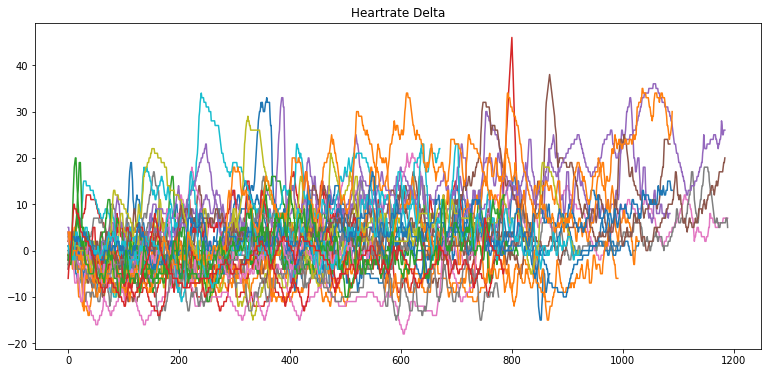

In [430]:
# Here we plotted all the original heartrates' deltas

col= dataset['Game0814-2']['b']['HR']
col = col[~np.isnan(col)]
dic = {}
games = ['Game0814-2', 'Game0816-6', 'Game0816-1', 'Game0816-7', 'Game0813-3', 'Game0813-4', 'Game0529-2', 'Game0529-5', 'Game0813-2', 'Game0529-3', 'Game0814-1', 'Game0816-2', 'Game0816-5', 'Game0816-4', 'Game0816-3', 'Game0529-1', 'Game0813-1']

for i in range(len(games)):
        dic['x'+str(i)+'b']=np.array(dataset[games[i]]['b']['HR'])
        dic['x'+str(i)+'w']=np.array(dataset[games[i]]['w']['HR'])
        col= dataset[games[i]]['b']['HR']
        col = col[~np.isnan(col)]
        #
heartrate = pd.DataFrame(dic)
time = dataset.index
plt.rcParams["figure.figsize"] = (13,6)
plt.title('Heartrate Delta')
plot = plt.plot(heartrate)



The graph represents all the heartrates collected by us in the dataset, or, more precisely, the delta of the dataset, computed in the following way: at each person's heartrate in every instant is subtracted the average of his heartrates taken in the first ten seconds of the game, assuming that in that moment he was calm and at rest.

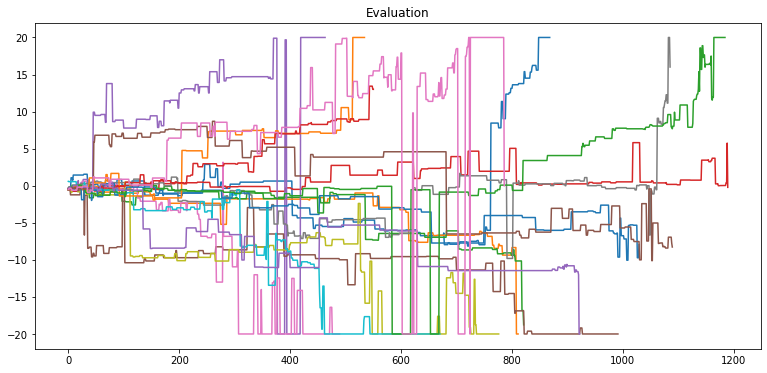

In [432]:
# Position evaluation functions, as we can see this graph is not very easy to read
col= dataset['Game0814-2']['b']['Evaluation']
col = col[~np.isnan(col)]
dic = {}
games = ['Game0814-2', 'Game0816-6', 'Game0816-1', 'Game0816-7', 'Game0813-3', 'Game0813-4', 'Game0529-2', 'Game0529-5', 'Game0813-2', 'Game0529-3', 'Game0814-1', 'Game0816-2', 'Game0816-5', 'Game0816-4', 'Game0816-3', 'Game0529-1', 'Game0813-1']

for i in range(len(games)):
        dic['x'+str(i)+'b']=np.array(dataset[games[i]]['b']['Evaluation'])

        # We will only print the black evaluations, since the white ones assume the same values but with the opposite sign. 
        #dic['x'+str(i)+'w']=np.array(realwage[games[i]]['w']['Evaluation'])

        col= dataset[games[i]]['b']['HR']
        col = col[~np.isnan(col)]
        
evaluation = pd.DataFrame(dic)
time = dataset.index
plt.title('Evaluation')
plot = plt.plot(evaluation)




Represented above we have all the position evaluations collected by us in dataset. With respect to the heartrate graph showed above, there are fewer lines and the plot is more readable, because we thought there was no sense in showing both the black and the white position evaluations for each game (they're the opposite, but equal in absolute value!).

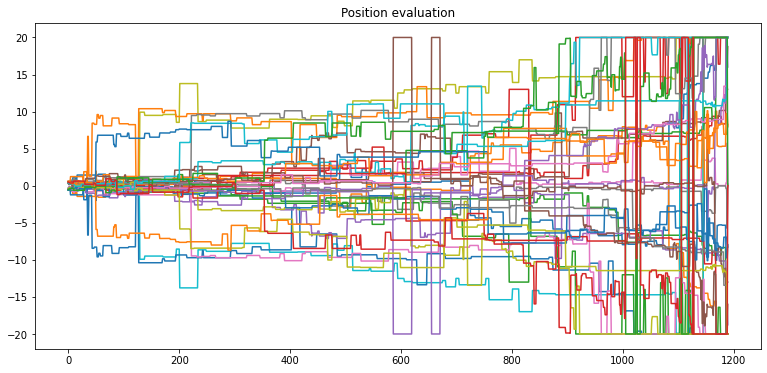

In [452]:
realwage = pd.read_csv("partite.csv")
realwage = realwage.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])
# X = pd.DataFrame({'x1':t,
#                    'x2': hb0})
realwage.dropna(axis=1)

dic = {}
games = ['Game0814-2', 'Game0816-6', 'Game0816-1', 'Game0816-7', 'Game0813-3', 'Game0813-4', 'Game0529-2', 'Game0529-5', 'Game0813-2', 'Game0529-3', 'Game0814-1', 'Game0816-2', 'Game0816-5', 'Game0816-4', 'Game0816-3', 'Game0529-1', 'Game0813-1']
for i in range(len(games)):
        dic['x'+str(i)+'b']=adjust(np.array(realwage[games[i]]['b']['Evaluation']), len(realwage))
        dic['x'+str(i)+'w']=adjust(np.array(realwage[games[i]]['w']['Evaluation']),len(realwage))
evaluation = pd.DataFrame(dic)
time = realwage.index
plt.plot(evaluation)
plot = plt.title('Position evaluation')


We used the function 'adjust' to solve the issue that every game has a different length from another; we plotted all the evaluations (both black and white) and it's visible that they all end at the same instant in time.

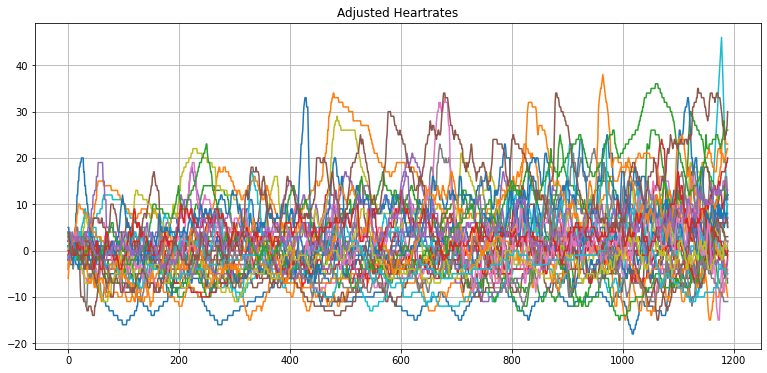

In [442]:

# Showing the adjusted heartrates (still using the delta)
dataset.dropna(axis=1)

dic = {}
games =['Game0813-2','Game0529-4','Game0813-4','Game0529-2','Game0816-6','Game0529-3','Game0816-1','Game0816-7','Game0814-1','Game0816-3','Game0813-1','Game0813-3','Game0816-2','Game0814-2','Game0816-4','Game0529-5','Game0816-5','Game0529-1']
for i in range(len(games)):
        dic['x'+str(i)+'b']=adjust(np.array(dataset[games[i]]['b']['HR']), len(dataset))
        dic['x'+str(i)+'w']=adjust(np.array(dataset[games[i]]['w']['HR']),len(dataset))
heartrate_adj = pd.DataFrame(dic)
time = dataset.index
plt.plot(heartrate_adj)
plt.title('Adjusted Heartrates')
plt.grid()
plt.show()



We did the same (using 'adjust' function) also with the heartrates.

Below we saved the two different (adjusted) dataset of interest with the pandas method to_csv

In [438]:
# heartrate.to_csv('heartrate.csv', index = False)
# evaluation.to_csv('evaluation.csv', index = False)

In [439]:
# Visualizing adjusted data
ds = pd.DataFrame()
for i in range(len(games)):
    newcol = adjust(np.array(dataset[games[i]]['b']['Evaluation']), len(dataset))
    ds[i] = newcol
ds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.55,-0.55,-0.40,-0.38,-0.42,-0.44,-0.57,-0.30,-0.55,0.59,-0.55,-0.55,-0.38,-0.40,-0.38,-0.57,-0.50
1,-0.55,-0.55,-0.40,-0.38,-0.37,-0.44,-0.57,-0.15,-0.52,0.55,-0.52,-0.55,-0.38,-0.40,-0.38,-0.57,-0.50
2,-0.55,-0.55,-0.40,-0.38,-0.37,-0.23,-0.57,-0.15,-0.52,0.55,-0.52,-0.55,-0.24,-0.40,-0.24,-0.57,-0.37
3,-0.55,-0.55,-0.40,-0.31,-0.37,-0.23,-0.43,-0.15,-0.52,0.55,-0.52,-0.55,-0.24,-0.40,-0.24,-0.45,-0.37
4,-0.55,-0.55,-0.45,-0.75,-0.37,-1.23,-0.43,-0.24,-0.52,0.55,-0.52,-0.55,-0.24,-0.40,-0.24,-0.45,-0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,20.00,-8.34,-10.15,0.03,20.00,-20.00,-20.00,11.14,-20.00,-20.00,-5.33,20.00,20.00,13.43,-11.59,-6.94,20.00
1186,20.00,-20.00,-16.83,0.39,20.00,-20.00,-20.00,20.00,-20.00,-20.00,-9.72,20.00,20.00,13.43,-11.59,-6.94,20.00
1187,20.00,-20.00,-16.83,0.39,20.00,-20.00,-20.00,20.00,-20.00,-20.00,-9.72,20.00,20.00,13.43,-12.00,-6.94,20.00
1188,20.00,-20.00,-16.83,5.75,20.00,-20.00,-20.00,20.00,-20.00,-20.00,-9.72,20.00,20.00,13.00,-20.00,-7.77,20.00


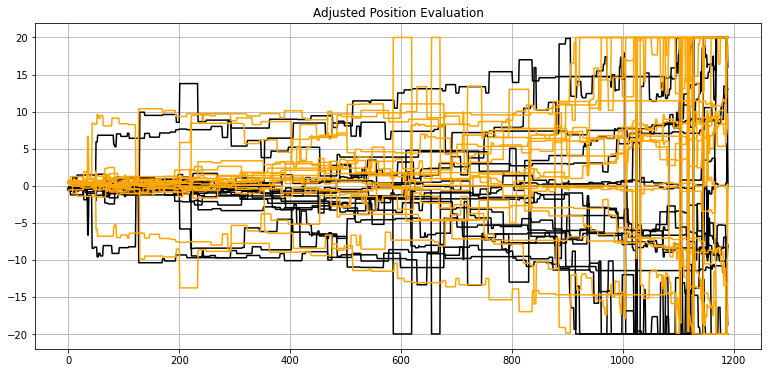

In [445]:
# Printing out the adjusted evaluations. In this graph we show the symmetric evaluations between black and white players.
dataset.dropna(axis=1)

dicw = {}
dicb = {}
games =['Game0813-2','Game0529-4','Game0813-4','Game0529-2','Game0816-6','Game0529-3','Game0816-1','Game0816-7','Game0814-1','Game0816-3','Game0813-1','Game0813-3','Game0816-2','Game0814-2','Game0816-4','Game0529-5','Game0816-5','Game0529-1']
for i in range(len(games)):
        dicb['x'+str(i)+'b']=adjust(np.array(dataset[games[i]]['b']['Evaluation']), len(dataset))
        dicw['x'+str(i)+'w']=adjust(np.array(dataset[games[i]]['w']['Evaluation']),len(dataset))
evaluationw = pd.DataFrame(dicw)
evaluationb = pd.DataFrame(dicb)
time = dataset.index
plt.plot(evaluationb, color='black')
plt.plot(evaluationw, color='orange')
plt.title('Adjusted Position Evaluation')
plt.grid()
plt.show()


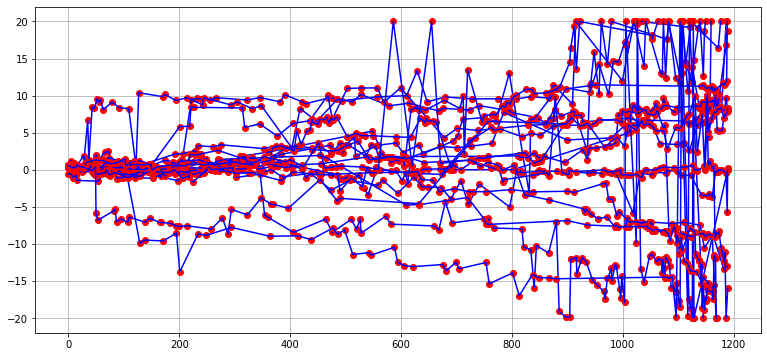

In [ ]:
# A clearer visualization of adjusted position evaluations, each red point represents a move
ds = pd.DataFrame()
for i in range(len(games)):
    newcol = adjust(np.array(dataset[games[i]]['w']['Evaluation']), len(dataset))
    ds[i] = newcol


for y in range(len(ds.columns)):
    eval = [ds[y][0]]
    te = [0]
    for x in range(1, len(ds[y])):
        
        if ds[y][x] != ds[y][x-1]:
            eval.append(ds[y][x])
            te.append(x)
    plt.plot(te, eval, 'ro', label="evaluation p.")
    plt.plot(te, eval, 'b', label="linear interpolation")


plt.grid()


We will keep using the adjusted data in order to simplyfy all the following operations. Another transformation that we can apply to our data for manipulating it in an easier way is smoothing.

#### Using a basis

In functional data analysis is common to use linear combinations of basis functions for representing data functions. 
A basis function system is a set of known, independent from each other, functions $ \phi_k$. The reason why basis function systems are used so much is that it's possible to approximate any function by taking a linear combination of basis functions. We can represent a function x(t) using K basis $ \phi_k$ with the following linear expansion:
$$ x(t) = \sum^K_{k=1} c_k \phi_k(t) $$

The most common used basis are the Fourier and the B-Spline basis. For our dataset we decided to use the B-Spline basis since our dataset doesn't represent periodic data, and a basis function should have the same features as the functions that it estimates.

The first thing that we do when using a spline basis is to divide the interval in which the funcion ranges, into L subintervals, those subintervals are called knots. Over each interval the spline will be a polynomial of order m. We decided to use 9 basis to approximate our evaluation function and we used the scikit-learn library for represent it graphically.


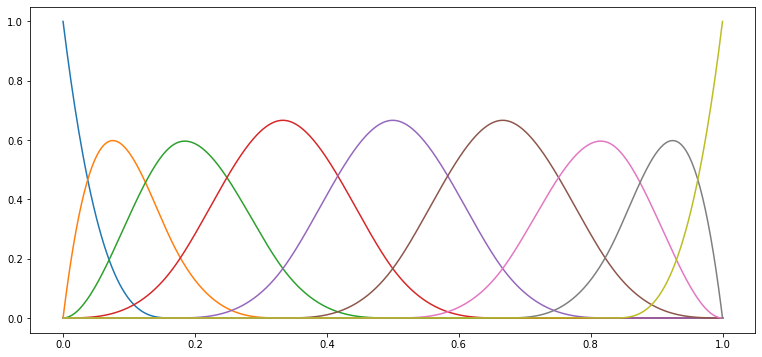

In [ ]:
#BSpline basis 9

basis = skfda.representation.basis.BSpline(n_basis=9)
basis.plot()
plt.show()

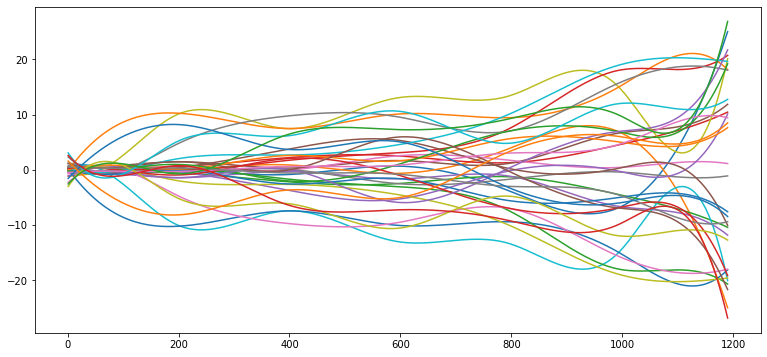

In [ ]:
# Smoothed evaluation
basis = skfda.representation.basis.BSpline(n_basis=9)

evaluation = pd.read_csv('evaluation.csv')
listona = []
for column in evaluation:
    lista = list(evaluation[column])
    listona.append(lista)

evaluation = skfda.FDataGrid(data_matrix=listona, sample_points=[*range(1, len(listona[0])+1)])
X = evaluation
X_basis = X.to_basis(basis)
fig = X_basis.plot()


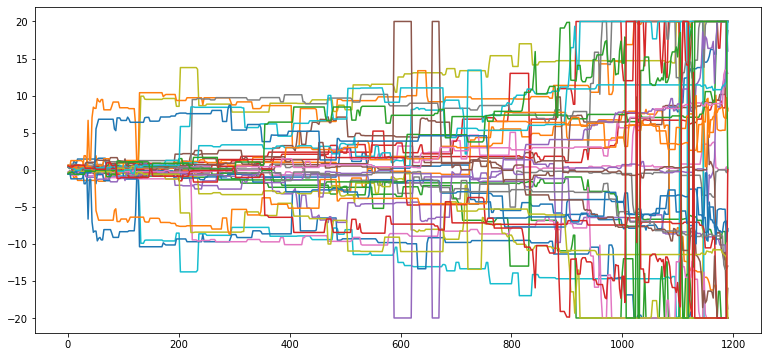

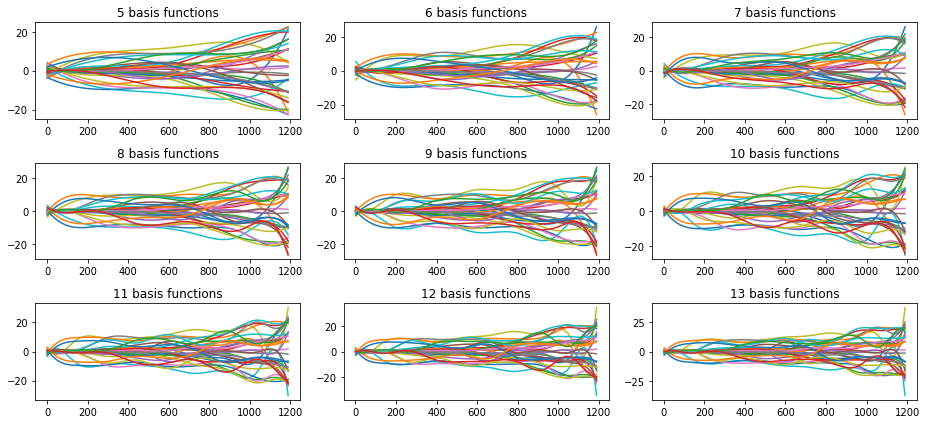

In [ ]:
# Checking different plots with 5 to 13 basis
max_basis = 13

evaluation = pd.read_csv('evaluation.csv')
listona = []
for column in evaluation:
    lista = list(evaluation[column])
    listona.append(lista)

evaluation = skfda.FDataGrid(data_matrix=listona, sample_points=[*range(1, len(listona[0])+1)])
X = evaluation

X.plot()

fig, axes = plt.subplots(nrows=3, ncols=3)

for n_basis in range(5, max_basis + 1):
    basis = skfda.representation.basis.BSpline(n_basis=n_basis)
    X_basis = X.to_basis(basis)

    ax = axes.ravel()[n_basis - 5]
    fig = X_basis.plot(axes=ax)
    ax.set_title(f"{n_basis} basis functions")

fig.tight_layout()
plt.show()

### Linear polynomial regression
 
A simple linear regression could not capture the pattern in the data, seen that it's not linear at all, and we occur in a case of underfitting. To overcome that we need to increase the complexity of the model, though it can be still considered as linear as the coefficients associated with the features are still linear.

Let $ (x_1,Y_1),...(x_n,Y_n)$ be a random sample of bivariate data. For all $ i,x_i $ belongs to $ R ^d $ and $ Y_i $ in $R$. Assume the following model:$ Y_i = f(x_i)+e_i $. We would like to estimate the unknown regression function $ f(x) = E[Y|X=x] $. To do so we use the LocalPolynomial method from FDApy.

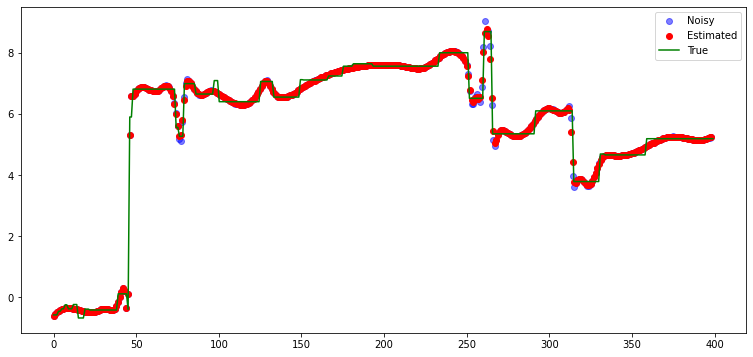

In [453]:


realwage = pd.read_csv("partite.csv")
realwage = realwage.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])
realwage=realwage.dropna(axis=0)

# Let's take only one evaluation to show this procedure more in depth
ev0 = realwage['Game0529-1']['b']['Evaluation'] 
t = realwage.index

spl = UnivariateSpline(t, ev0)
spl.set_smoothing_factor(10)
#predicted evaluation smoothing
ev0_pred = spl(t)

# Let's fit the local polynomials
lp = LocalPolynomial(kernel_name="epanechnikov", bandwidth=2, degree=2)
t = np.array(t)
lp.fit(t, ev0_pred)


# Plot the results
plt.scatter(t, ev0_pred, alpha=0.5, color='blue', label='Noisy')
plt.scatter(np.sort(t), lp.X_fit_, color='red', label='Estimated')
plt.plot(np.linspace(0, 399, 399), ev0, 'green', label='True')
plt.legend()


The method detones the data considered "noisy", the purple points, and the curve never approaches them.

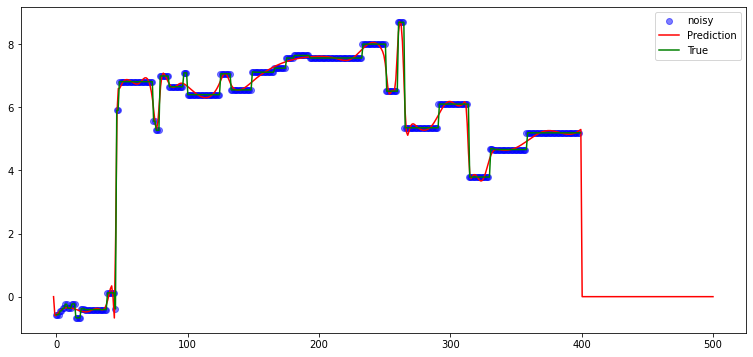

In [435]:
# Now we estimate the curve on a grid
y_pred = lp.predict(np.linspace(-2, 500, 500))
plt.scatter(t, ev0, alpha=0.5, color='blue', label='noisy')
plt.plot(np.linspace(-2, 500, 500), y_pred, color='red', label='Prediction')
plt.plot(np.linspace(0, 399, 399), ev0, 'green', label='True')
plot =plt.legend()


We can see that the predicted curve is a good approximation of the future data.

### Functional linear model

We will now try to find a linear model concerning how losing or winning a game influences the heart-rate, considering the heart-beat as our functional dependent variable. In order to do so we will first start by dividing the players' data in winners and loosers, then we will use some simple statistical methods that we will use to find the liner model afterwords.

Let's start now with the basics: the mean and standard deviation of functional data are the same for traditional data.

Mean: $ \bar{x}(t) = \frac{1}{N} \sum_{i=1}^{N} x_i(t) $

Standadar deviation: $ \sqrt{\frac{1}{N-1} \sum_{i=1}^{N} [x_i(t)-\bar{x}(t)]^2} $

Then we will also find the grand mean, that is the average of all the means of our heartrate functions.

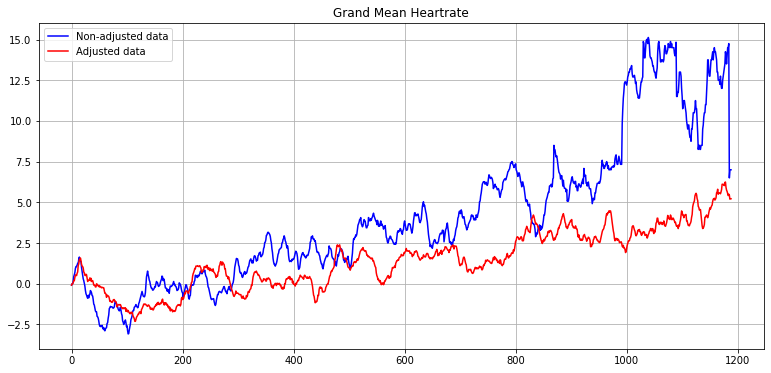

In [436]:
#Grand Mean plot

dic = {}
games =['Game0813-2','Game0529-4','Game0813-4','Game0529-2','Game0816-6','Game0529-3','Game0816-1','Game0816-7','Game0814-1','Game0816-3','Game0813-1','Game0813-3','Game0816-2','Game0814-2','Game0816-4','Game0529-5','Game0816-5','Game0529-1']
for i in range(len(games)):
        dic['x'+str(i)+'b']=np.array(dataset[games[i]]['b']['HR'])
        dic['x'+str(i)+'w']=np.array(dataset[games[i]]['w']['HR'])
        
heartrate = pd.DataFrame(dic)
time = dataset.index

tim = ds.index
mean_x=[i for i in range(max(tim))]
mean_y = [(heartrate_adj.loc[i]).mean() for i in mean_x]

mean_x_axis = [i for i in range(max(time))]
mean_y_axis = [(heartrate.loc[i]).mean() for i in mean_x_axis]
plt.grid()
plt.plot(mean_x_axis, mean_y_axis, 'b')
plt.plot(mean_x, mean_y, 'r')
plt.title('Grand Mean Heartrate')
plot =plt.legend(['Non-adjusted data', 'Adjusted data'])

From this single plot we can observe that the mean given by the data that was left untouched reached higher heart rate increase levels, this might be caused by the increase of pressure given by the time passing by, and being less and less after each move. 

We can notice that after 16/17 minutes, so when the time left for each player is around 2 minutes, the majority of the players has a big increase in the heart beat. This behaviour is not well represented by the adjusted data, for this reason for the following analysis we will use the raw data, without adjustments.

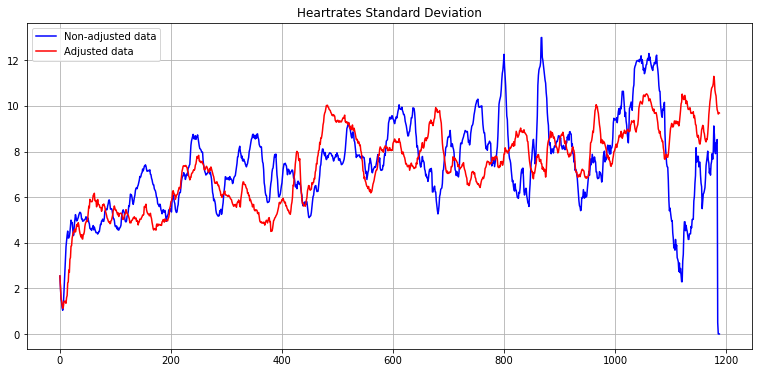

In [ ]:
#Standard deviation plot

dic = {}
games =['Game0813-2','Game0529-4','Game0813-4','Game0529-2','Game0816-6','Game0529-3','Game0816-1','Game0816-7','Game0814-1','Game0816-3','Game0813-1','Game0813-3','Game0816-2','Game0814-2','Game0816-4','Game0529-5','Game0816-5','Game0529-1']

for i in range(len(games)):
        dic['x'+str(i)+'b']=np.array(dataset[games[i]]['b']['HR'])
        dic['x'+str(i)+'w']=np.array(dataset[games[i]]['w']['HR'])
        
heartrate = pd.DataFrame(dic)
time = dataset.index

tim = ds.index
std_x=[i for i in range(max(tim))]
std_y = [np.std(heartrate_adj.loc[i]) for i in mean_x]

std_x_axis = [i for i in range(max(time))]
std_y_axis = [np.std(heartrate.loc[i]) for i in std_x_axis]
plt.grid()
plt.plot(std_x_axis, std_y_axis, 'b')
plt.plot(std_x, std_y, 'r')
plt.title('Heartrates Standard Deviation')
plt.legend(['Non-adjusted data', 'Adjusted data'])

We can notice that the standard deviation of the adjusted data is following a general and quite steady increasing behaviour in standard deviation, caused by the "strech" of the heartbeats in the adjusted dataset. While the raw data's standard deviation reaches higher values but with time, and with the decrease of considered games, the deviation from the mean decreases drastically.

Now we want to see if and how the heart beat is infuenced by winning or loosing, or better, we want to analyze the different behaviours in the heartbeats of winners and loosers.
The model for the ith heart beat function will then be:

$ hb_{il}(t) = \mu(t)+\alpha_l (t) + \epsilon_{il} (t)$ for the loosers, and

$ hb_{iw}(t) = \mu(t)+\alpha_l (t) + \epsilon_{iw} (t)$ for the winners.

Where $\mu(t)$ is the mean across all the heartbeats, $\alpha_l(t)$ is the effect function (in this case of the loosers), representing how much the mean of the loosers differentiates from the grand mean, and $\epsilon_{il} (t)$ is the residuals function. 

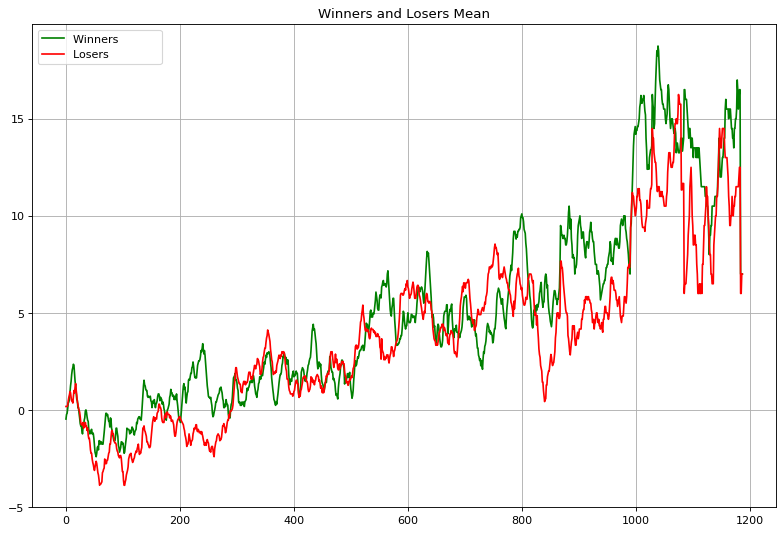

In [ ]:

figure(figsize=(12, 8), dpi=80)

realwage = pd.read_csv('prova.csv')
realwage = realwage.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])

# Separating winners and losers heartbeats
winners = {'Game0814-2':'b', 'Game0816-6':'w', 'Game0816-1':'w', 'Game0816-7':'b', 'Game0813-3':'b', 'Game0813-4':'w', 'Game0529-2':'w', 'Game0529-5':'b', 'Game0813-2':'w', 'Game0529-4':'w', 'Game0529-3':'w', 'Game0814-1':'w', 'Game0816-2':'b', 'Game0816-5':'b', 'Game0816-4':'w', 'Game0816-3':'w', 'Game0529-1':'b', 'Game0813-1':'b'}
games =['Game0813-2','Game0813-4','Game0529-2','Game0816-6','Game0529-3','Game0816-1','Game0816-7','Game0814-1','Game0816-3','Game0813-1','Game0813-3','Game0816-2','Game0814-2','Game0816-4','Game0529-5','Game0816-5','Game0529-1']
dic_winners={}
dic_losers = {}
for el in games:
        if winners[el] == 'b':
                dic_winners[el+'b']=np.array(realwage[el]['b']['HR'])
                dic_losers[el+'w']=np.array(realwage[el]['w']['HR'])
        if winners[el] == 'w':
                dic_winners[el+'w']=np.array(realwage[el]['w']['HR'])
                dic_losers[el+'b']=np.array(realwage[el]['b']['HR'])
winn = pd.DataFrame(dic_winners)
lose = pd.DataFrame(dic_losers)


timew = winn.index
mean_x_axisw = [i for i in range(max(timew))]
mean_y_axisw = [(winn.loc[i]).mean() for i in mean_x_axisw]

timel = lose.index
mean_x_axisl = [i for i in range(max(timel))]
mean_y_axisl = [(lose.loc[i]).mean() for i in mean_x_axisl]
plt.grid()
plt.plot(mean_x_axisw, mean_y_axisw, 'green')
plt.plot(mean_x_axisl,mean_y_axisl,'red')
plt.title('Winners and Losers Mean')
plt.legend(['Winners           ', 'Losers           '])

spl = UnivariateSpline(mean_x_axisw, mean_y_axisw)

sple = UnivariateSpline(mean_x_axisl, mean_y_axisl)
sple.set_smoothing_factor(10)
spl.set_smoothing_factor(5)



We can clearly observe from the graph above that the winners and losers mean are really similar, although the loser mean is usually lower than the winner's one, but it is not enough to see a pattern.

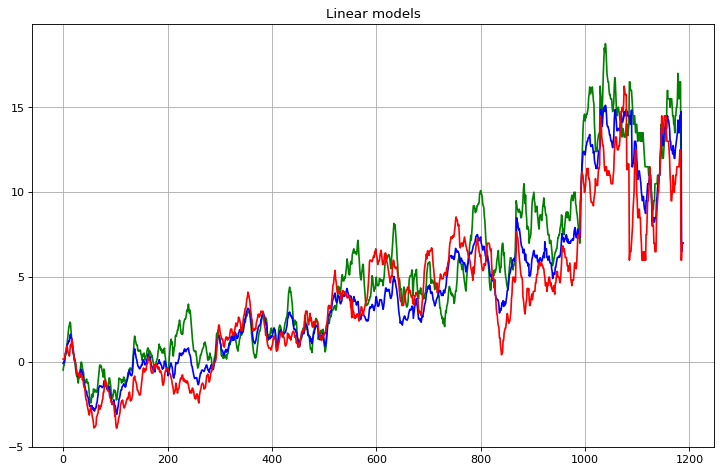

In [ ]:
# Linear models plot



figure(figsize=(11, 7), dpi=80)
diffw_y = [(-mean_y_axis[i] +mean_y_axisw[i]) for i in range(len(mean_x_axisw))]
diffl_y = [(-mean_y_axis[i] + mean_y_axisl[i]) for i in range(len(mean_x_axisl))]

mod = [mean_y_axis[i] +diffw_y[i] for i in range(len(mean_x_axisw))]
mod2 = [mean_y_axis[i] +diffl_y[i] for i in range(len(mean_x_axisl))]
#plt.plot(mean_x_axisw, diffw_y, 'green')
#plt.plot(mean_x_axisw, diffl_y, 'red')
plt.plot(mean_x_axisw, mod, 'g')
plt.plot(mean_x_axis, mean_y_axis, 'b')
plt.plot(mean_x_axisl, mod2, 'r')
plt.title('Linear models')
plt.grid()
plt.show()


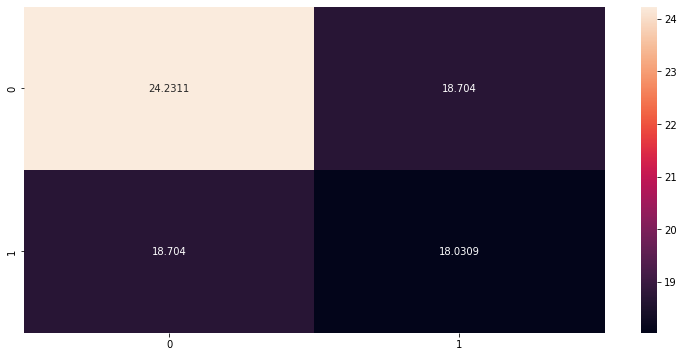

array([[24.23114686, 18.7040042 ],
       [18.7040042 , 18.03085254]])

In [ ]:
# covariance matrix between losers mean and winners mean
import seaborn as sn
cov = np.cov(mod, mod2)
sn.heatmap(cov, annot=True, fmt='g')
plt.show()
cov

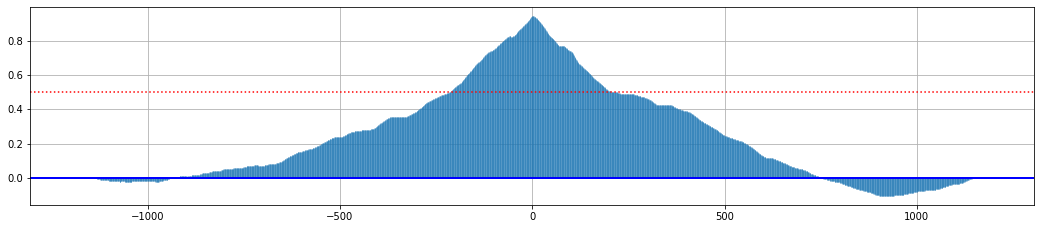

In [ ]:
import scipy
import matplotlib.pyplot as plt

# Plot graph
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig.set_size_inches(18,8)

# cross correlation using xcorr() function
ax1.xcorr(mod, mod2, usevlines=True,
          maxlags=1187, normed=True,
          lw=0.5 )
# adding grid to the graph
ax1.grid(True)
ax1.axhline(0, color='blue', lw=2)
plt.axhline(0.5, linestyle='dotted', color='red')
# show final plotted graph
plt.show()



By looking at the covariance matrix and at the cross-correlation graph, we can say that at the beginning of the games there's a strong positive correlation between winners and losers, this result is probably given by the fact that at the start of each game, the two players are not distinguishable yet in loser and winner, so their heartbeats are quite similar, and they follow the same trend. After around 4 minutes, we suppose that the roles of winner and loser will start to be aknowledged by the players, and the correlation between the heartbeats will decrease. After approximately 15 minutes from the beginning of the game, the correlation will become slightly negative, and we suppose that this inversion of trend is due to the different moods of the players.


### One-way Functional ANOVA test

Now we will use the ANOVA test for comparing the means of winners and losers. We will divide the dataset in two different groups. Then we are going to apply the ANOVA procedure to each group to test if the means of the  groups are similar or not.
We will use one-way ANOVA test, that considers only one functional response variable and one unique variable of input.

The anova function implements an asymptotic method to test the following null hypothesis:

Let $ {X_i}_{i=1}^k $ be a set of $ k $ independent samples each one with $ n_i $ trajectories, and let $ E(X_i) = m_i(t) $.
The null hypothesis is defined as:
$$ H_0 = m_1(t)= ...= m_k (t) $$
The function that calculates the value of the statistic is v_sample_stat() $ V_n $ with the means of the given samples. Under the null hypothesis this statistic is asymptotically equivalent to v_asymptotic_stat(), where each sample is replaced by a gaussian process, with mean zero and the same covariance function as the original.

The simulation of the distribution of the asymptotic statistic $ V $ is implemented using a bootstrap procedure. One observation of the $ k $ different gaussian processes defined above is simulated, and the value of v_asymptotic_stat() is calculated. This procedure is repeated n_reps times, creating a sampling distribution of the statistic.

At the end we will get a p-value that will be able to tell us if we can reject the null hypothesis (so that the means are not the same) or if we aren't able to accept the null hypothesis.

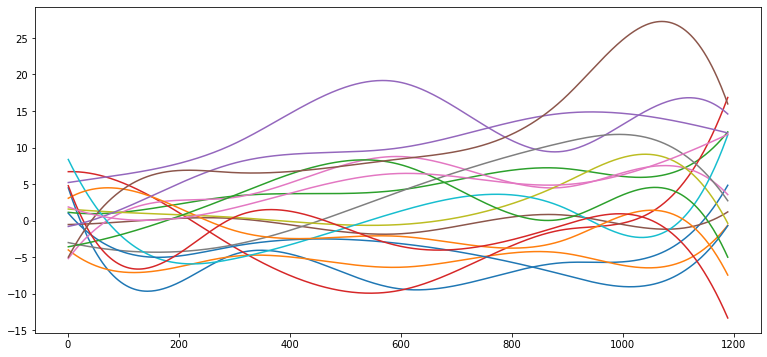

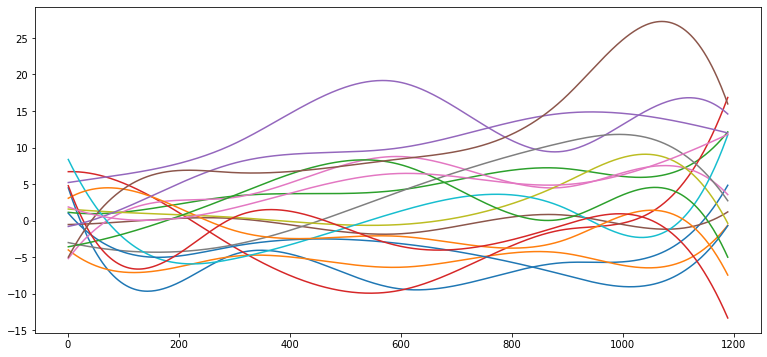

In [ ]:
#The functions will then be projected to the functional basis, solving a least squares problem in order to find the 
# optimal coefficients of the expansion
heartrate = pd.read_csv('heartrate.csv')
hr = []
winn_forgrid = []
lose_forgrid = []
winners = {'Game0814-2':'b', 'Game0816-6':'w', 'Game0816-1':'w', 'Game0816-7':'b', 'Game0813-3':'b', 'Game0813-4':'w', 'Game0529-2':'w', 'Game0529-5':'b', 'Game0813-2':'w', 'Game0529-4':'w', 'Game0529-3':'w', 'Game0814-1':'w', 'Game0816-2':'b', 'Game0816-5':'b', 'Game0816-4':'w', 'Game0816-3':'w', 'Game0529-1':'b', 'Game0813-1':'b'}
games =['Game0813-2','Game0813-4','Game0529-2','Game0816-6','Game0529-3','Game0816-1','Game0816-7','Game0814-1','Game0816-3','Game0813-1','Game0813-3','Game0816-2','Game0814-2','Game0816-4','Game0529-5','Game0816-5','Game0529-1']
dic_winners={}
dic_losers = {}
for el in games:
        if winners[el] == 'b':
                dic_winners[el+'b']=adjust(np.array(realwage[el]['b']['HR']), len(realwage))
                dic_losers[el+'w']=adjust(np.array(realwage[el]['w']['HR']), len(realwage))
        if winners[el] == 'w':
                dic_winners[el+'w']=adjust(np.array(realwage[el]['w']['HR']), len(realwage))
                dic_losers[el+'b']=adjust(np.array(realwage[el]['b']['HR']), len(realwage))
winn = pd.DataFrame(dic_winners)
lose = pd.DataFrame(dic_losers)

for column in heartrate:
    lista = list(heartrate[column])
    hr.append(lista)

for column in winn:
    listo = list(winn[column])
    winn_forgrid.append(listo)

for column in lose:
    listu = list(lose[column])
    lose_forgrid.append(listu)

heartrate = skfda.FDataGrid(data_matrix=hr, sample_points=[*range(1, len(hr[0])+1)])
basis = skfda.representation.basis.BSpline(n_basis=7)
winners =  skfda.FDataGrid(data_matrix=winn_forgrid, sample_points=[*range(1, len(winn_forgrid[0])+1)])
W_basis = winners.to_basis(basis)
# Plotting the winners smoothed heartrate
W_basis.plot()


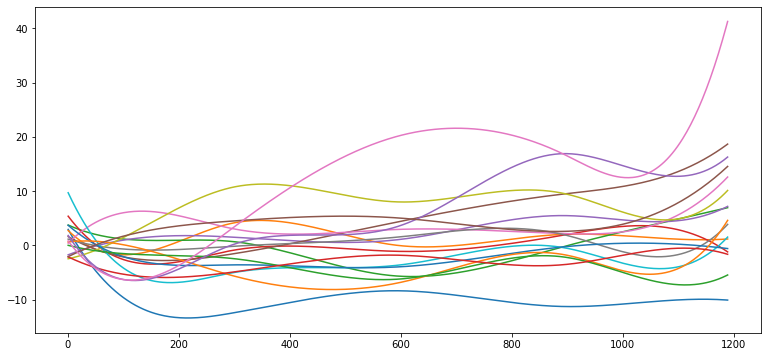

In [ ]:
# Plotting the smoothed hr of the losers
losers = skfda.FDataGrid(data_matrix=lose_forgrid, sample_points=[*range(1, len(lose_forgrid[0])+1)])
L_basis = losers.to_basis(basis)
L_basis.plot()
plt.show()


In [ ]:

basis = skfda.representation.basis.BSpline(n_basis=5)
L_basis = losers.to_basis(basis)
W_basis = winners.to_basis(basis)


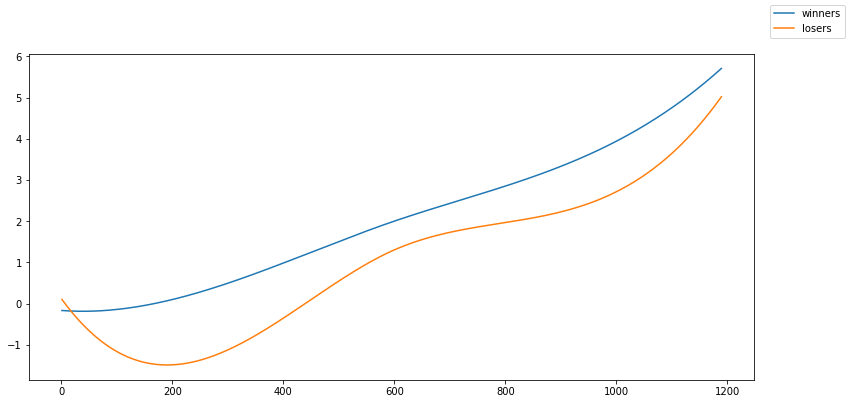

In [ ]:
# Compared means
means = [W_basis.mean(), L_basis.mean()]

fd_means = skfda.concatenate(means)
fig = fd_means.plot()
fig.legend(['winners','losers'])



As we have seen before in our analysis, we observe two main things:
- first of all, the losers' heartrate stays below the winners' one during all the match (exluding time = 0 where we have that the two intersect eachother). We can imagine that this is caused by the winner thinking more (and better) about the move, causing an increase in his heartrate, and that he recognizes his mistakes.

- at least but not last, there is a generale increase in both heartrates during the game, an important information if we'd want to understand in which phase of the game the players are (opening, middlegame and ending) only based on the players' heartrates.

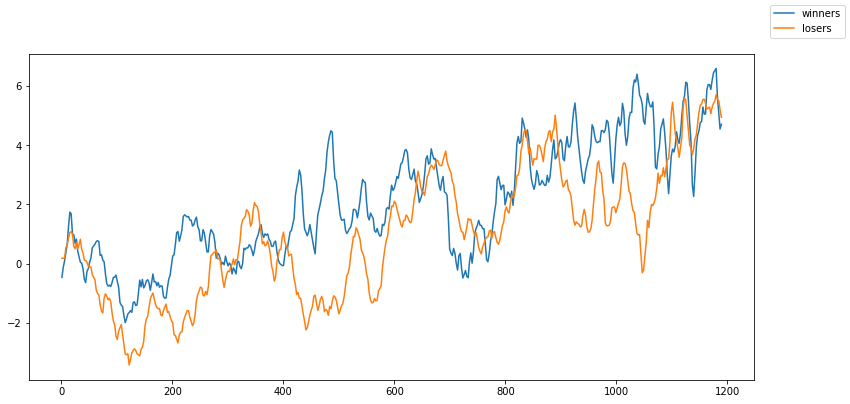

In [ ]:

means = [winners.mean(), losers.mean()]

fd_means = skfda.concatenate(means)
fig = fd_means.plot()
fig.legend(['winners','losers'])




In [ ]:

statistic_value, p_value, distribution = oneway_anova(W_basis, L_basis, n_reps=1500,return_dist=True)

print('Statistic: ', statistic_value)
print('p-value: ', p_value)
print('Distribution: ', distribution)

Statistic:  25152.0002344961
p-value:  0.7633333333333333
Distribution:  [ 79236.28279802  85245.67421458   7237.25934475 ... 230522.56183459
   8260.51936111  47232.40935994]


The method returns a tuple containing the value of the sample statistic, p-value and sampling distribution of the simulated asymptotic statistic.
The p-value is equal to 0.7, then we can't reject the null hypothesis.

### Functional Principal Component Analysis (FPCA)
We had a nice overlook at our data, we found some interesting information but we still haven't expoited a tool that is very useful when it comes to FDA, and this tool is FPCA. Functional principal component analysis (FPCA) is a statistical method for exploring the data and discovering characteristic behaviours of functional data. This method consists in representing a random function in the eigenbasis, which is an orthonormal basis of the Hilbert space L2. FPCA might be one of the best methods for extrapolating data features, and it was between the first methods that were considered in the early literature of functional data analysis. The main advantage is that the eigenfunction basis explains more variation than any other basis expansion, when using a fixed number of basis functions.

For this part of the analysis we will perform FPCA in different ways, first discretized FPCA and then we will convert the data with different basis, our hypothesis is that the BSpline basis will be the basis that works better with our data, and through the visualization of different plots, we'll find out if it's true that we can distinguish winners' heartbeats from losers' heartbeats through FPCA.

The first approach is discretized FPCA, that consists in looking only at the raw data, without any basis transformation. We impose 2 components and we fit them.

Text(0.5, 1.0, 'Two components')

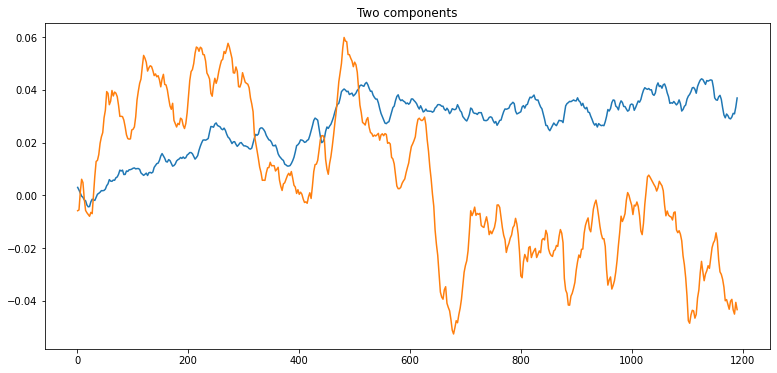

In [ ]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction.projection import FPCA


heartrate = pd.read_csv('heartrate.csv')
hr = []
for column in heartrate:
    lista = list(heartrate[column])
    hr.append(lista)


heartrate = skfda.FDataGrid(data_matrix=hr, sample_points=[*range(1, len(hr[0])+1)])
fpca_disc = FPCA(n_components=2)
fpca_disc.fit(heartrate)
fpca_disc.components_.plot()
plt.title('Two components')


As we can see, there isn't a clear distinction between the two functions, so we proceed with further analysis. We apply FPCA to data that was first converted using a basis representation. The first basis that we use is the BSpline, with seven basis functions.

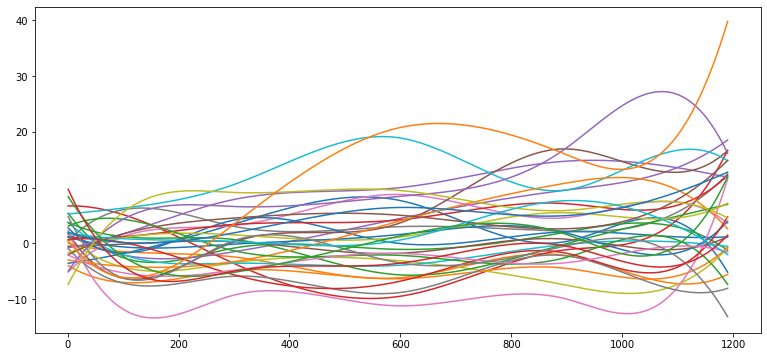

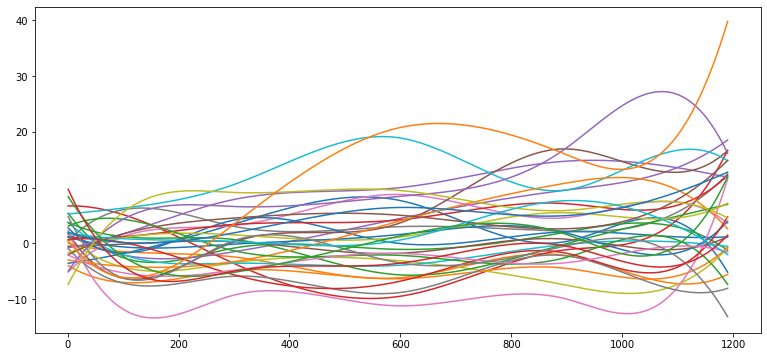

In [ ]:
basis = skfda.representation.basis.BSpline(n_basis=7)
basis_hr = heartrate.to_basis(basis)
basis_hr.plot()

Now that we built a Basis object, we fit the new two principal components using the basis.

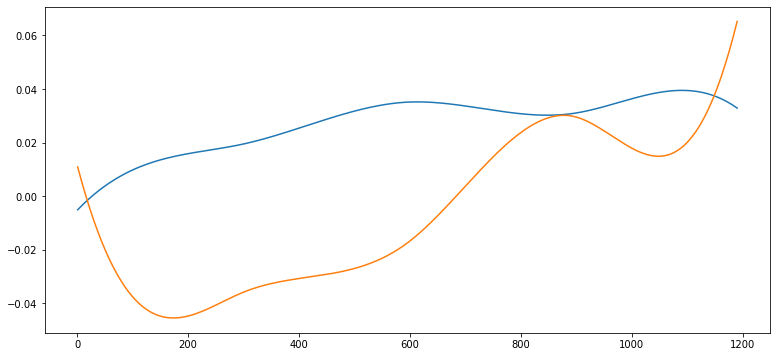

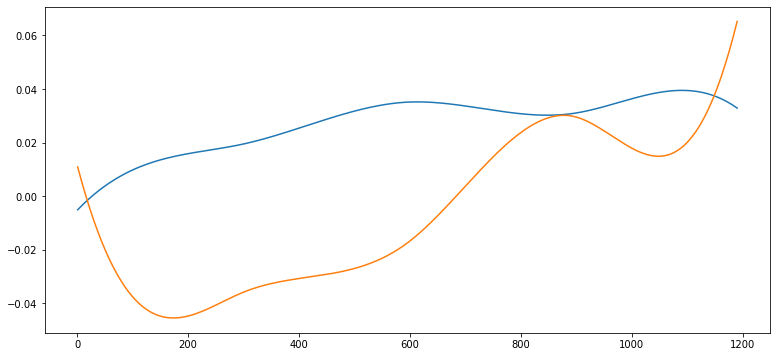

In [ ]:
fpca = FPCA(n_components=2)
fpca.fit(basis_hr)
fpca.components_.plot()

To have a better look at the effects of the obtained two principal components, we add (Principal component 1) and subtract (Principal component 2) a multiple of the components, in our case 40, to the mean function through the FPCAPlot function. With this graphs we can hypothesize that the first one represents the difference in heartbeat increase between winners and losers, at first the changes of the heart rate's delta is the same, but towards the end the winners have a bigger increase; while for the second plot we could interpret it as the behaviour of the heartbeats, since we saw that the winners usually have a heartbeat decrease at the beginning of the game and a strong increase of heartbeat towards the end.

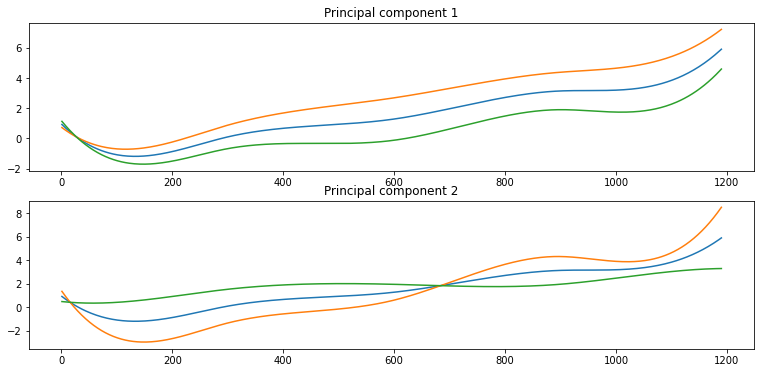

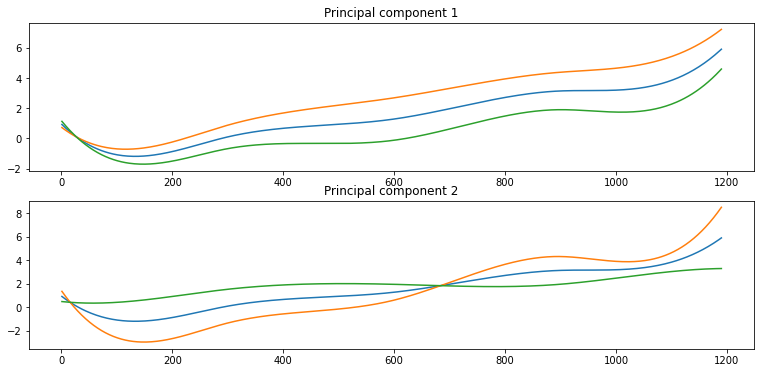

In [ ]:
FPCAPlot(
    basis_hr.mean(),
    fpca.components_,
    multiple=40,
    n_rows=2,
    
).plot()

If we would have used a Fourier basis instead, the behaviour of the components would have been sinusoidal, and it wouldn't have been correspondent to the actual behaviour of the data.

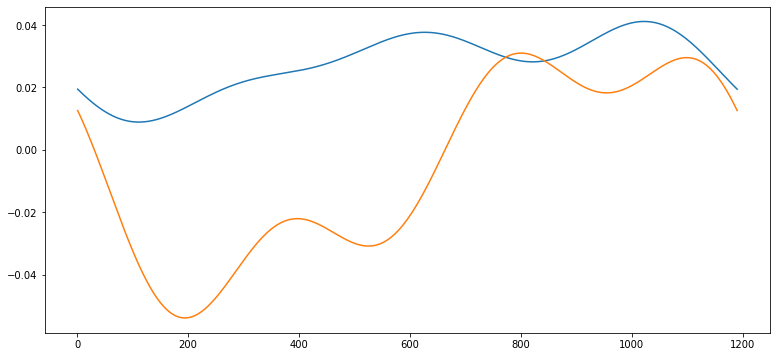

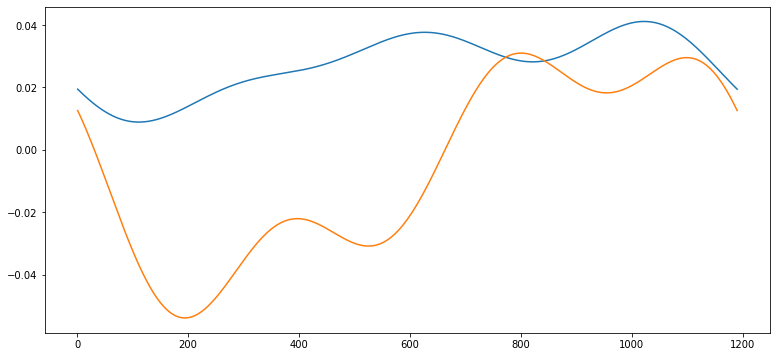

In [ ]:
from skfda.representation.basis import BSpline
from skfda.representation.basis import Fourier
# Fourier basis
basis_hr = heartrate.to_basis(Fourier(n_basis=7))
fpca = FPCA(n_components=2, components_basis=Fourier(n_basis=7))
fpca.fit(basis_hr)
fpca.components_.plot()


### Neighbours functional regression

By using k-neighbours functional regression, we will try to predict a possible evaluation position score using past heartrate data, we will use the neighboring points to the new point of interest to predict what the future value might be. 

First we divide the dataset in two and we take into account only the data of the white players, than we transpose these data into a data grid with the skfda module FDataGrid.

In [ ]:
# Importing libraries
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
import numpy as np
import skfda
from skfda.ml.regression import KNeighborsRegressor
from skfda.preprocessing.dim_reduction.projection import FPCA


heartrate = pd.read_csv('heartrate.csv')
hr = []
#taking only the whites' evaluation
for column in heartrate.loc[:, ::2]:
    lista = list(heartrate[column])
    hr.append(lista)
heartrate = skfda.FDataGrid(data_matrix=hr, sample_points=[*range(1, len(hr[0])+1)])

evaluation = pd.read_csv('evaluation.csv')
ev = []
for column in evaluation.loc[:, ::2]:
    listt = list(evaluation[column])
    ev.append(listt)
evaluation = skfda.FDataGrid(data_matrix=ev, sample_points=[*range(1, len(ev[0])+1)])



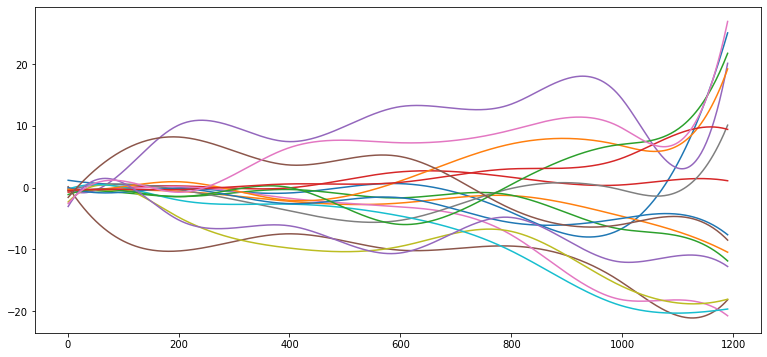

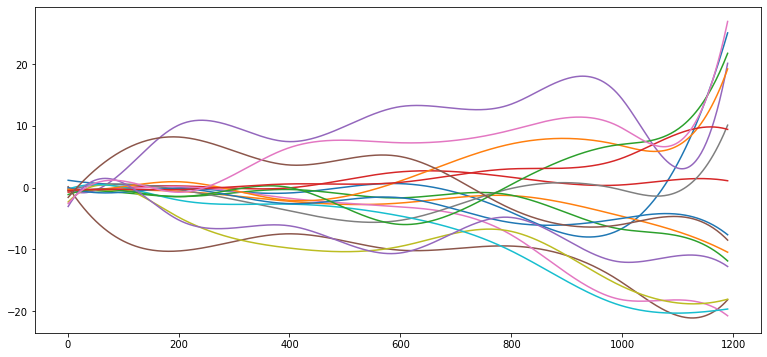

In [ ]:
# Here we smooth the evaluation function with 9 BSpline basis
basis = skfda.representation.basis.BSpline(n_basis=9)
evaluation = evaluation.to_basis(basis)
evaluation.plot()

In [ ]:
# Now we split the dataset in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    heartrate,
    evaluation,
    test_size=0.15,
    random_state=2,
)



Here we calculate the score for some possible k number of neighbours. The $ R^2 $ coefficient for functional data is given by the following formula:

$
1-\frac{\sum_{i=1}^n \int (ev_i(t)-\hat{ev}_i(t))^2 dt}{\sum_{i=1}^n \int (ev_i(t)-\frac{1}{n} \sum_{i=1}^n ev_i(t))^2 dt}
$

Where $ev_i$ are the actual responses and $\hat{ev}_i$ are the predicted responses.

The best score that we could get is 1, but any score greater that 0.0 represents a better prediction than a random one.  

In [ ]:
# k scores for k neighbours
for k in range(2, 13):
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    print('k: '+str(k)+', score: '+ str(score))


k: 2, score: 0.30354535967126217
k: 3, score: 0.132394942686482
k: 4, score: 0.04258238224261046
k: 5, score: 0.08208612011825556
k: 6, score: 0.0369977174074666
k: 7, score: -0.08737230144815755
k: 8, score: -0.19855308358188606
k: 9, score: -0.24155936576620096
k: 10, score: -0.23705097988948998
k: 11, score: -0.17364146238804112
k: 12, score: -0.1303002457623601


Using only two neighbours we obtain the highest score (0.35), so we will proceed using k=2

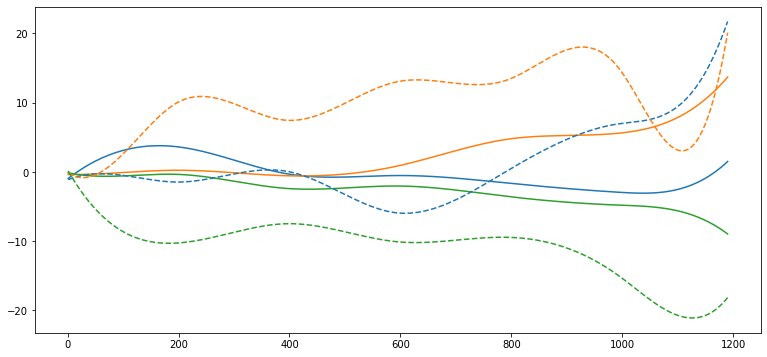

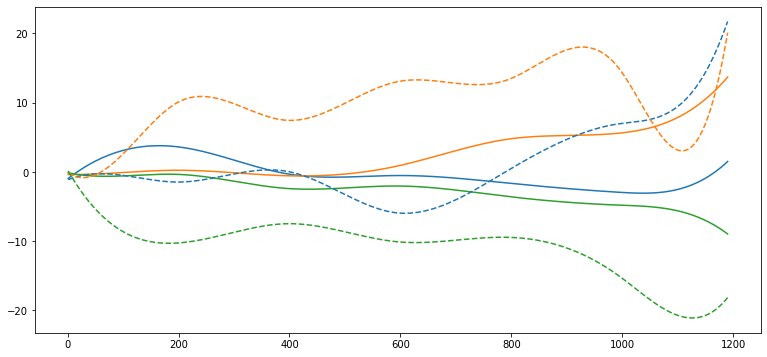

In [ ]:
# Trying  to make a prediction using 2 neighbors and Euclidean distance. 

knn = KNeighborsRegressor(n_neighbors=2, weights='distance')
knn.fit(X_train, y_train)

# Let's look at the predict values 

y_pred = knn.predict(X_test)

# Plot prediction
fig = y_pred.plot()
fig.axes[0].set_prop_cycle(None)  # Reset colors
y_test.plot(fig=fig, linestyle='--')

The prediction result that we obtained is not the best; from this analysis we can conclude that the heartrate might not be the best indicator for predicting evaluation, but it still gave us a useful hint for the evaluation position.